In [119]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

# scale back and remmove negative values
# apply gradient dexcent attack on benign sample -> scale back + delta + modify sample by adding bytes

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from pdfid import pdfid

In [120]:
data = pd.read_csv('PDFMalware2022.csv').dropna()
data.columns

Index(['Fine name', 'pdfsize', 'metadata size', 'pages', 'xref Length',
       'title characters', 'isEncrypted', 'embedded files', 'images', 'text',
       'header', 'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer',
       'startxref', 'pageno', 'encrypt', 'ObjStm', 'JS', 'Javascript', 'AA',
       'OpenAction', 'Acroform', 'JBIG2Decode', 'RichMedia', 'launch',
       'EmbeddedFile', 'XFA', 'Colors', 'Class'],
      dtype='object')

In [121]:
new_labels = {'Malicious': 1, 'Benign': 0}
data['Class'] = data['Class'].map(new_labels)


new_labels = {'1(1)': '1', '2(1)': '2', '3(1)': '3', '29(2)': '29', '34(2)': '34', '2(2)': '2', '>': '0', '53(1)': '53', '5(1)': '5', '12(2)': '2', '53(2)': '53', '-1': '0', 
              '(most': '0', '_Pro_Rodeo_Pix_': '0', "_Pro_Rodeo_Pix_'": '0', 'pdfid.py': '0', 'pdfHeader)': '0', 'bytes[endHeader]': '0', 'list': '0', 'unclear': '0', 'Yes': '1', 'No': '0'}

for col in data.drop(columns=['Class']).columns:
    data[col] = data[col].replace(new_labels)

data.head()

,Fine name,pdfsize,metadata size,pages,xref Length,title characters,isEncrypted,embedded files,images,text,...,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,launch,EmbeddedFile,XFA,Colors,Class
0,aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129...,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0.0,1
1,fe767fb2584a10c010626263ea950643ac25f6ca24628f...,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,0,...,0,0,1,0,0,0,8,1,0.0,1
2,544c5223ee301affad514b6fa585b3191625aba0a7222b...,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,0.0,1
3,669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe15...,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,0,...,0,1,1,0,0,0,0,0,0.0,1
4,e434c884f45a691b0bf33d765f61794007eb0b8bb9f590...,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,0.0,1


In [122]:
print(data['Class'])

data.describe()

0        1
1        1
2        1
3        1
4        1
        ..
10021    1
10022    1
10023    1
10024    1
10025    1
Name: Class, Length: 10023, dtype: int64


,pdfsize,metadata size,pages,xref Length,title characters,isEncrypted,embedded files,stream,trailer,encrypt,ObjStm,Colors,Class
count,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000,10023.000000
mean,87.225581,334.130101,3.398583,2728.630650,51.487479,-0.020852,-0.006485,17.341215,1.203532,-0.043500,1.516811,2.087000,0.554225
std,444.239972,1566.007897,11.903610,18108.388189,1354.775001,0.206809,0.257123,35.330169,1.370455,0.256045,7.633485,58.178074,0.497076
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,9.000000,180.000000,1.000000,12.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,265.000000,1.000000,21.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,80.000000,319.000000,2.000000,77.000000,13.000000,0.000000,0.000000,18.000000,2.000000,0.000000,0.000000,0.000000,1.000000
max,23816.000000,77185.000000,595.000000,263987.000000,76993.000000,4.000000,5.000000,812.000000,46.000000,2.000000,600.000000,5682.000000,1.000000


In [123]:
class_data = data.drop(columns=['Fine name', 'header', 'Class'])

x_train, x_test, y_train, y_test = train_test_split(class_data, data['Class'], test_size=0.2, random_state=77)
x_train.shape

(8018, 30)

In [124]:
# Normalize or scale features
normalizer = RobustScaler()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)

pd.DataFrame(x_train, columns=class_data.columns).head()

,pdfsize,metadata size,pages,xref Length,title characters,isEncrypted,embedded files,images,text,obj,...,Javascript,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,launch,EmbeddedFile,XFA,Colors
0,0.140845,0.260870,2.0,0.184615,0.615385,0.0,0.0,0.0,1.0,0.410256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.619718,0.840580,1.0,5.353846,1.307692,0.0,0.0,0.0,1.0,1.153846,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0
2,-0.112676,0.021739,0.0,-0.138462,0.000000,0.0,0.0,1.0,0.0,-0.179487,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.028169,0.920290,3.0,7.630769,2.307692,0.0,0.0,0.0,1.0,4.230769,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.042254,1.971014,3.0,4.553846,5.923077,0.0,0.0,0.0,1.0,26.282051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [125]:
# Naive Bayes
nb = GaussianNB()
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

nb_accuracy = accuracy_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred)
nb_recall = recall_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred)

print(f"""Naive Bayes scores
      accuracy score: {nb_accuracy}
      precision score: {nb_precision}
      recall score: {nb_recall}
      f1 score: {nb_recall}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")


Naive Bayes scores
      accuracy score: 0.7047381546134663
      precision score: 0.9702276707530648
      recall score: 0.49069973427812225
      f1 score: 0.49069973427812225

Confusion matrix:
[[859  17]
 [575 554]]


In [126]:
tree = DecisionTreeClassifier(max_depth=100)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)

dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)

print(f"""Decision tree scores
      accuracy score: {dt_accuracy}
      precision score: {dt_precision}
      recall score: {dt_recall}
      f1 score: {dt_f1}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

Decision tree scores
      accuracy score: 0.9900249376558603
      precision score: 0.9920141969831411
      recall score: 0.9902568644818424
      f1 score: 0.9911347517730497

Confusion matrix:
[[ 867    9]
 [  11 1118]]


In [127]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print(f"""Random forest scores
      accuracy score: {rf_accuracy}
      precision score: {rf_precision}
      recall score: {rf_recall}
      f1 score: {rf_f1}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

Random forest scores
      accuracy score: 0.9935162094763093
      precision score: 0.9955595026642984
      recall score: 0.9929140832595217
      f1 score: 0.9942350332594235

Confusion matrix:
[[ 871    5]
 [   8 1121]]


In [128]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)

print(f"""KNN scores
      accuracy score: {knn_accuracy}
      precision score: {knn_precision}
      recall score: {knn_recall}
      f1 score: {knn_recall}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

KNN scores
      accuracy score: 0.9770573566084788
      precision score: 0.9847806624888094
      recall score: 0.9743135518157662
      f1 score: 0.9743135518157662

Confusion matrix:
[[ 859   17]
 [  29 1100]]


In [129]:
hidden_layers = (128,)
activation = 'logistic'
solver = 'adam'

mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation, solver=solver)
mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_test)

mlp_accuracy = accuracy_score(y_test, y_pred)
mlp_precision = precision_score(y_test, y_pred)
mlp_recall = recall_score(y_test, y_pred)
mlp_f1 = f1_score(y_test, y_pred)

print(f"""MLP scores
      accuracy score: {mlp_accuracy}
      precision score: {mlp_precision}
      recall score: {mlp_recall}
      f1 score: {mlp_recall}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

MLP scores
      accuracy score: 0.9885286783042394
      precision score: 0.9928698752228164
      recall score: 0.9867139061116031
      f1 score: 0.9867139061116031

Confusion matrix:
[[ 868    8]
 [  15 1114]]


/home/paul/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [130]:
test_data_svm = data.sample(frac=1).reset_index(drop=True)[:4000]
# print(test_data_svm['Class'])
used_data_svm = test_data_svm.drop(columns=['Fine name', 'header', 'Class'])
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(used_data_svm, test_data_svm['Class'], test_size=0.2, random_state=69)

x_train_svm = normalizer.fit_transform(x_train_svm)
x_test_svm = normalizer.transform(x_test_svm)

C_values = [1, 0.8, 0.5, 0.3, 0.1]
for c in C_values:
    svc = SVC(kernel='linear', C=c)
    svc.fit(x_train_svm, y_train_svm)
    y_pred = svc.predict(x_test_svm)
    print(f"C = {c}, F1: {f1_score(y_test_svm, y_pred)}")

C = 1, F1: 0.959409594095941
C = 0.8, F1: 0.9605911330049262
C = 0.5, F1: 0.9558823529411765
C = 0.3, F1: 0.9548229548229549
C = 0.1, F1: 0.9631449631449631


In [131]:
# SVM
# svc = SVC(kernel='linear')
# svc.fit(x_train, y_train)
svc = SVC(kernel='linear', C=1)
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print(f"""SVM scores
      accuracy score: {svm_accuracy}
      precision score: {svm_precision}
      recall score: {svm_recall}
      f1 score: {svm_f1}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")


SVM scores
      accuracy score: 0.9536159600997506
      precision score: 0.9850187265917603
      recall score: 0.9317980513728964
      f1 score: 0.9576695493855257

Confusion matrix:
[[ 860   16]
 [  77 1052]]


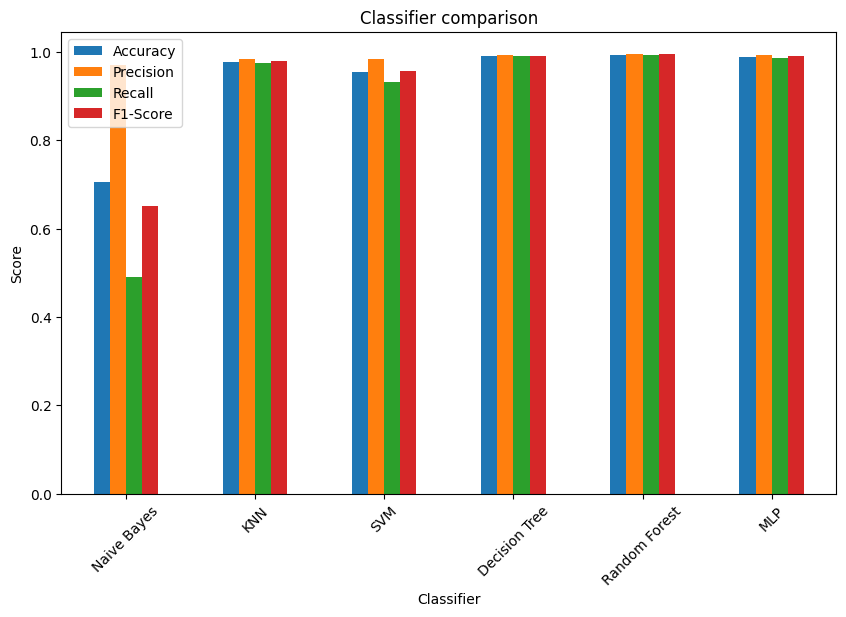

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

results = {
    "Classifier": ["Naive Bayes", "KNN", "SVM", "Decision Tree", "Random Forest", "MLP"],
    "Accuracy": [nb_accuracy, knn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy, mlp_accuracy],
    "Precision": [nb_precision, knn_precision, svm_precision, dt_precision, rf_precision, mlp_precision],
    "Recall": [nb_recall, knn_recall, svm_recall, dt_recall, rf_recall, mlp_recall],
    "F1-Score": [nb_f1, knn_f1, svm_f1, dt_f1, rf_f1, mlp_f1]
}
df_results = pd.DataFrame(results)

##Code to display the results
df_results.plot(kind='bar', x='Classifier', figsize=(10, 6))
plt.title('Classifier comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_1061614/2332541769.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(sorted_dict.keys())[::-1], x=list(sorted_dict.values())[::-1], palette='mako')


Text(0.5, 1.0, 'Features importance')

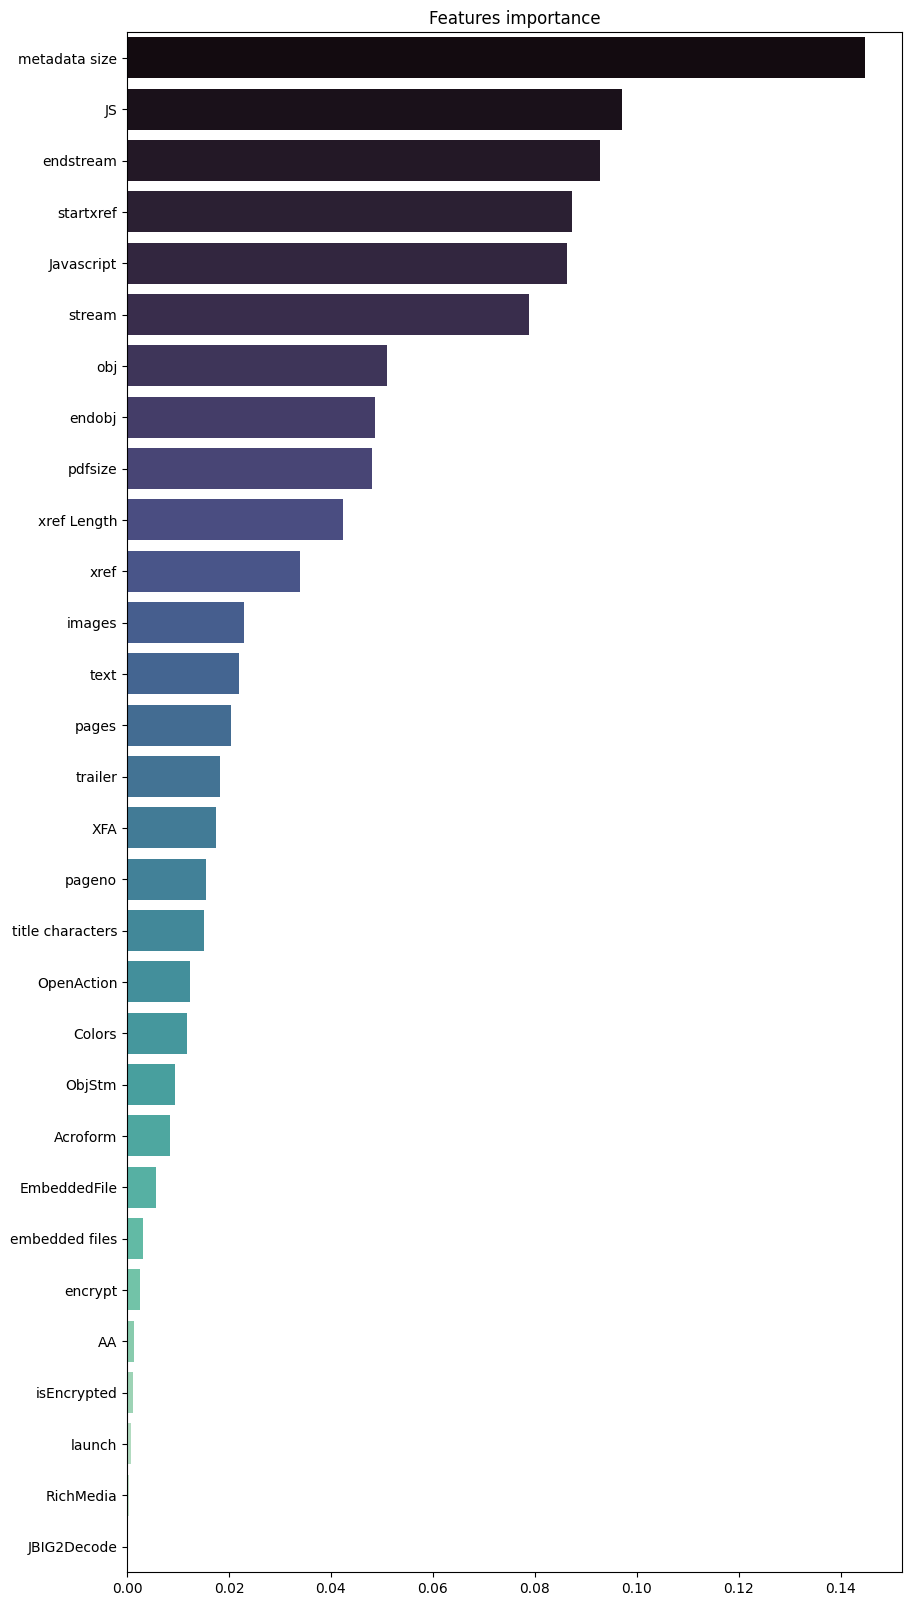

In [133]:
# Feature importance
importance = rf.feature_importances_
importance_dict = {class_data.columns.values[i]: importance[i] for i in range (len(importance))}
sorted_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1])}
plt.figure(figsize=(10, 20))
sns.barplot(y=list(sorted_dict.keys())[::-1], x=list(sorted_dict.values())[::-1], palette='mako')
plt.title('Features importance')



In [134]:
def evasion_gradient_descent(x0, gradient, t, epsilon, max_iter):

    m = 0
    x_m = x0
    for i in range(max_iter):

        m += 1
        x_m = x_m - t * gradient
        # print(f"Iteration {i}...")
        if np.linalg.norm(x_m - x0) < epsilon:
            break

    x = x_m
    return x_m


def rbf_kernel(x, x_i, gamma=0.0001):
    return np.exp(- gamma * np.pow(np.linalg.norm(x - x_i), 2))

def poly_kernel(x, x_i, d=3, c=1):
    return np.pow((x @ x_i) + c, d)

def gradient_rbf_kernel(x, x_i, gamma):
    return -2 * gamma * np.exp(- gamma * np.pow(np.linalg.norm(x - x_i), 2)) * (x - x_i)

def gradient_poly_kernel(x, x_i, d, c):
    return d * np.pow(d * (x @ x_i + c), d - 1) * x_i

def evasion_gradient_descent_with_kernel(x0, y, gradient, t, h, l, epsilon, max_iter):

    m = 0
    x_m = x0

    for i in range(max_iter):

        estimator = delta_f = np.zeros(gradient.shape[0])
        for i in range(y.shape[0]):
            estimator += 0

        x_m = x_m - t * gradient 
        print(f"Iteration {i}...")
        if np.linalg.norm(x_m - x0) < epsilon:
            break
        m += 1

    x = x_m
    return x_m


In [135]:
malicious_sample = class_data[data['Class'] == 1].iloc[-3:-2]
print(malicious_sample.iloc[0])
pred = mlp.predict(malicious_sample)
pred

pdfsize               4.0
metadata size       377.0
pages                 2.0
xref Length          13.0
title characters     11.0
isEncrypted           0.0
embedded files        0.0
images                  0
text                    1
obj                     8
endobj                  8
stream                2.0
endstream               2
xref                    1
trailer               1.0
startxref               1
pageno                  1
encrypt               0.0
ObjStm                0.0
JS                      1
Javascript              1
AA                      0
OpenAction              1
Acroform                0
JBIG2Decode             0
RichMedia               0
launch                  0
EmbeddedFile            0
XFA                     0
Colors                0.0
Name: 10023, dtype: object


/home/paul/.local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([1])

In [140]:
# SVM
gamma_values = [1, 1/1000, 1/x_train_svm.shape[0], 1/10**6]
for g in gamma_values:
     svc_rbf = SVC(kernel='rbf', gamma=g)
     svc_rbf.fit(x_train_svm, y_train_svm)
     y_pred = svc_rbf.predict(x_test_svm)
     print(f"Gamma = {g}, F1: {f1_score(y_test_svm, y_pred)}")

svc_rbf = SVC(kernel='rbf', gamma=0.001)
svc_rbf.fit(x_train_svm, y_train_svm)

y_pred = svc_rbf.predict(x_test_svm)

svm_rbf_accuracy = accuracy_score(y_test_svm, y_pred)
svm_rbf_precision = precision_score(y_test_svm, y_pred)
svm_rbf_recall = recall_score(y_test_svm, y_pred)
svm_rbf_f1 = f1_score(y_test_svm, y_pred)

print(f"""\nSVM with rbf kernel scores
      accuracy score: {svm_rbf_accuracy}
      precision score: {svm_rbf_precision}
      recall score: {svm_rbf_recall}
      f1 score: {svm_rbf_f1}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test_svm, y_pred)}")

Gamma = 1, F1: 0.8751677852348994
Gamma = 0.001, F1: 0.9515738498789347
Gamma = 0.0003125, F1: 0.9385342789598109
Gamma = 1e-06, F1: 0.6892003297609234

SVM with rbf kernel scores
      accuracy score: 0.95
      precision score: 0.9632352941176471
      recall score: 0.9401913875598086
      f1 score: 0.9515738498789347

Confusion matrix:
[[367  15]
 [ 25 393]]


In [137]:
coef_values = [0, 5, 10]
degrees = [1, 2, 4, 7]

for c in coef_values:
    for d in degrees:
       svc_poly = SVC(kernel='poly', coef0=c, degree=d)
       svc_poly.fit(x_train_svm, y_train_svm)
       y_pred = svc_poly.predict(x_test_svm)
       print(f"Constant = {c}, degree = {d}, F1: {f1_score(y_test_svm, y_pred)}")
print()


svc_poly = SVC(kernel='poly', coef0=5, degree=7)
svc_poly.fit(x_train_svm, y_train_svm)
y_pred = svc_poly.predict(x_test_svm)

svm_poly_accuracy = accuracy_score(y_test_svm, y_pred)
svm_poly_precision = precision_score(y_test_svm, y_pred)
svm_poly_recall = recall_score(y_test_svm, y_pred)
svm_poly_f1 = f1_score(y_test_svm, y_pred)

print(f"""SVM with rbf poly scores
      accuracy score: {svm_poly_accuracy}
      precision score: {svm_poly_precision}
      recall score: {svm_poly_recall}
      f1 score: {svm_poly_f1}\n""")
print(f"Confusion matrix:\n{confusion_matrix(y_test_svm, y_pred)}")

Constant = 0, degree = 1, F1: 0.7165217391304348
Constant = 0, degree = 2, F1: 0.6869350862777321
Constant = 0, degree = 4, F1: 0.6863711001642037
Constant = 0, degree = 7, F1: 0.6863711001642037
Constant = 5, degree = 1, F1: 0.7165217391304348
Constant = 5, degree = 2, F1: 0.8366701791359326
Constant = 5, degree = 4, F1: 0.9424460431654677
Constant = 5, degree = 7, F1: 0.9831730769230769
Constant = 10, degree = 1, F1: 0.7165217391304348
Constant = 10, degree = 2, F1: 0.8707182320441988
Constant = 10, degree = 4, F1: 0.966952264381885
Constant = 10, degree = 7, F1: 0.9819494584837545

SVM with rbf poly scores
      accuracy score: 0.9825
      precision score: 0.9879227053140096
      recall score: 0.9784688995215312
      f1 score: 0.9831730769230769

Confusion matrix:
[[377   5]
 [  9 409]]


In [138]:
def svm_gradient(weights, feature_vector=None, support_vectors=None, kernel='linear', gamma=0.001, d=3, c=0):
    if kernel == 'linear':
        return weights
    
    delta_g = np.zeros(feature_vector.shape)
    kernel_gradient = np.zeros(feature_vector.shape)
    for i in range(support_vectors.shape[0]):
        w_i = weights[i]
        x_i = support_vectors[i]
        if kernel == 'rbf':
            kernel_gradient = gradient_rbf_kernel(feature_vector, x_i, gamma)
        elif kernel == 'poly':
            kernel_gradient = gradient_poly_kernel(feature_vector, x_i, d, c)
        # print(f"delta_g: {delta_g.shape}, weights: {weights.shape}, kernel_gradient: {kernel_gradient.shape}")
        delta_g = delta_g + w_i * kernel_gradient
    return delta_g

In [139]:
x = malicious_sample.iloc[0].to_numpy().astype(int)
x = normalizer.fit_transform([x])[0]

weights_linear = svc.coef_[0]
bias_linear = svc.intercept_
print(f"x: {x.shape}")

gradient_linear = weights_linear
print(f"Linear weights:\n{gradient_linear}")

gamma = svc_rbf.get_params()['gamma']
weights_rbf = svc_rbf.dual_coef_[0]
# print(f"{x_train_svm.iloc[svc_rbf.support_].head()}")
support_vectors_rbf = svc_rbf.support_vectors_ # x_train_svm.iloc[svc_rbf.support_].to_numpy().astype(int)
print(f"Gamma: {gamma}, Weights: {weights_rbf.shape}, Support Vectors: {support_vectors_rbf.shape}")

rbf_gradient = svm_gradient(
    weights=weights_rbf,
    feature_vector=x,
    support_vectors=support_vectors_rbf,
    kernel='rbf',
    gamma=gamma
    )
print(f"RBF gradient: {rbf_gradient.shape}\n{rbf_gradient}")


d = svc_poly.get_params()['degree']
c = svc_poly.get_params()['coef0']
weights_poly = svc_poly.dual_coef_[0]
support_vectors_poly = svc_poly.support_vectors_ # x_train_svm.iloc[svc_poly.support_].to_numpy().astype(int)
print(f"Degree: {d}, Constant: {c}, Weights: {weights_poly.shape}, Support Vectors: {support_vectors_poly.shape}")

poly_gradient = svm_gradient(
    weights=weights_poly,
    feature_vector=x,
    support_vectors=support_vectors_poly,
    kernel='poly',
    d=d,
    c=c
    )
print(f"Poly gradient: {poly_gradient.shape}\n{poly_gradient}")

x: (30,)
Linear weights:
[-1.02111043e-03 -2.03453697e-03  2.49956070e-03  3.46592401e-03
  1.66106370e-03 -2.55299528e+00  2.94158012e-01 -5.87299077e-03
 -3.34471680e-01 -6.48139115e-01  1.41718807e-01  1.25722102e-02
 -2.02826286e-01 -3.44271752e+00  1.50476108e+00  8.12713019e-02
  3.03070279e-02 -3.45129174e+00  2.11700539e-02 -7.75199359e-01
  1.32342997e+00 -1.02504906e+00  1.61758376e+00  2.60161465e-02
 -9.70079308e-02  2.67760348e+00  3.67760348e+00  4.55382211e-02
  3.06697064e+00  1.54116225e-02]
Gamma: 1, Weights: (2125,), Support Vectors: (2125, 30)
RBF gradient: (30,)
[-0.58987211 -1.41681039 -0.20961312 -0.1225869  -0.12147512  0.01415442
  0.1299814  -0.77451323 -0.75601501 -0.07785539 -0.05459426  0.08274398
  0.05354583 -0.28114321 -0.01620644 -0.12583302 -0.69045741  0.00144759
  0.01831121  0.38738158  0.32830502  0.01141564  0.52114949  0.3002073
 -0.11425097  0.00605774  0.26093092  0.14464238  0.29262577  0.02960285]
Degree: 7, Constant: 5, Weights: (269,), Supp